# Community
In this notebook, I try to explore details about Wikipedia's core community, it's registered users. I try to understand how the block changed the levels of activity of users and try to implement new metrics for analysis.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm

In [11]:
DATA_PATH = '/dlabdata1/turkish_wiki'
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15', utc = True)]

## I. Preprocessing registered account edits for analysis

In [5]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/account_edits.csv', index_col = 0)
edits.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ira/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event_type,event_timestamp,event_user_id,event_user_groups,event_user_revision_count,event_user_seconds_since_previous_revision,page_id,page_title,page_revision_count,revision_minor_edit,revision_text_bytes,revision_text_bytes_diff,revision_is_identity_revert
1,create,2002-12-05 22:54:39+00:00,1,NaN,1,NaN,5,Main_Page,1.0,False,24,24.0,False
14,create,2003-03-13 16:30:04+00:00,6,NaN,1,NaN,10,Cengiz_Han,1.0,False,8540,8540.0,False
51,create,2003-08-02 01:08:44+00:00,13,NaN,2,303.0,24,Linux,1.0,False,257,257.0,False
52,create,2003-08-02 01:10:08+00:00,13,NaN,3,84.0,24,Linux,2.0,False,259,2.0,False
53,create,2003-08-02 01:11:50+00:00,13,NaN,4,102.0,24,Linux,3.0,False,261,2.0,False


In [6]:
# Select subset of columns, convert Data types
edits = edits[['event_user_id', 'event_timestamp', 'page_id','page_revision_count', 
               'revision_minor_edit', 'revision_text_bytes','revision_is_identity_revert']]
edits[['revision_minor_edit','revision_is_identity_revert']] = edits[['revision_minor_edit','revision_is_identity_revert']].convert_dtypes()
edits['event_timestamp'] = pd.to_datetime(edits['event_timestamp'],   utc = True)

### Find precise timestamp of the ban
#### Find end of blocking

In [7]:
registrations = pd.read_csv(f'{DATA_PATH}/processed_data/all_registrations.csv')

In [8]:
registrations.head()

,date,user_id
0,2005-09-08 00:14:22+00:00,2985
1,2005-09-08 00:38:01+00:00,2986
2,2005-09-08 06:48:49+00:00,2987
3,2005-09-08 08:37:43+00:00,2988
4,2005-09-08 09:07:11+00:00,2989


In [9]:
registrations['date'] = pd.to_datetime(registrations['date'],   utc = True)

In [12]:
zoom_after_block = registrations[(registrations['date'] > block_dates[1]-pd.Timedelta(days=1)) & (registrations['date'] < block_dates[1]+pd.Timedelta(days=1)) ]
zoom_after_block = zoom_after_block.set_index('date')
zoom_after_block = zoom_after_block.groupby(pd.Grouper(freq= 'H')).count().reset_index()

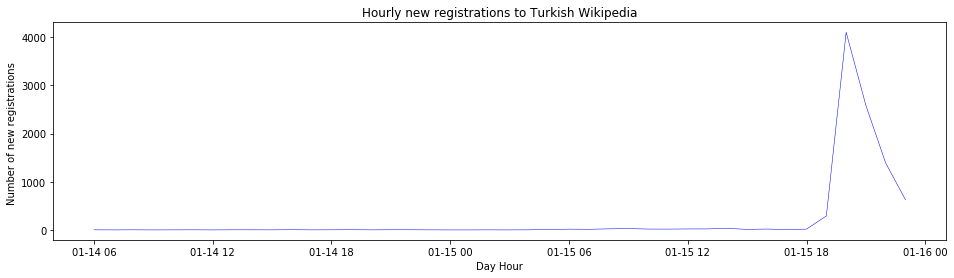

In [13]:
plt.figure(figsize=(16,4))
plt.title("Hourly new registrations to Turkish Wikipedia")
plt.plot(zoom_after_block['date'].values, zoom_after_block['user_id'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations ")
plt.xlabel("Day Hour")
plt.show()

In [14]:
zoom_after_block.tail(10)

,date,user_id
32,2020-01-15 14:00:00+00:00,30
33,2020-01-15 15:00:00+00:00,12
34,2020-01-15 16:00:00+00:00,18
35,2020-01-15 17:00:00+00:00,8
36,2020-01-15 18:00:00+00:00,17
37,2020-01-15 19:00:00+00:00,291
38,2020-01-15 20:00:00+00:00,4102
39,2020-01-15 21:00:00+00:00,2579
40,2020-01-15 22:00:00+00:00,1385
41,2020-01-15 23:00:00+00:00,624


The block seems to have ended at 7pm on the 2020-01-15.

#### Finding the beginning of the block

In [15]:
zoom_before_block = registrations[(registrations['date'] > block_dates[0]-pd.Timedelta(days=3)) & (registrations['date'] < block_dates[0]+pd.Timedelta(days=3)) ]
zoom_before_block = zoom_before_block.set_index('date')
zoom_before_block = zoom_before_block.groupby(pd.Grouper(freq= 'H')).count().reset_index()

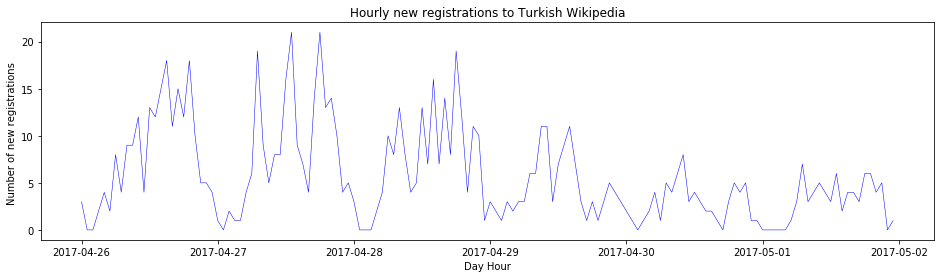

In [18]:
plt.figure(figsize=(16,4))
plt.title("Hourly new registrations to Turkish Wikipedia")
plt.plot(zoom_before_block['date'].values, zoom_before_block['user_id'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations ")
plt.xlabel("Day Hour")
plt.show()

In [19]:
zoom_before_block = edits[(edits['event_timestamp'] > block_dates[0]-pd.Timedelta(days=1)) & (edits['event_timestamp'] < block_dates[0]+pd.Timedelta(days=1)) ]
zoom_before_block = zoom_before_block.set_index('event_timestamp')
zoom_before_block = zoom_before_block.groupby(pd.Grouper(freq= 'H')).count().reset_index()

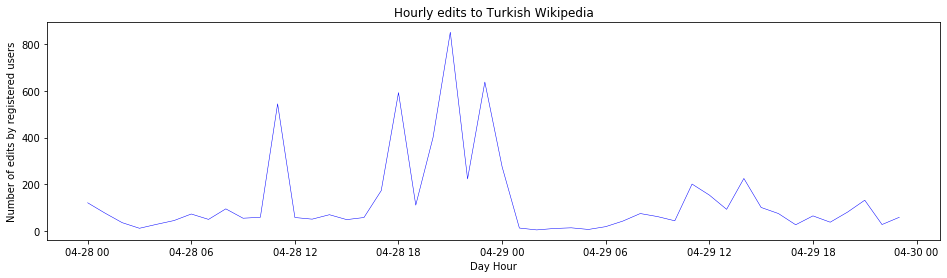

In [24]:
plt.figure(figsize=(16,4))
plt.title("Hourly edits to Turkish Wikipedia")
plt.plot(zoom_before_block['event_timestamp'].values, zoom_before_block['event_user_id'], color='blue', lw=0.5)
plt.ylabel("Number of edits by registered users")
plt.xlabel("Day Hour")
plt.show()

In [30]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]
blocked_days = (block_dates[1] - block_dates[0]).days

In [23]:
edits['period'] = np.nan
edits.loc[edits['event_timestamp'] < block_dates[0], 'period'] = 'pre-block'
edits.loc[(edits['event_timestamp'] >= block_dates[0]) & (edits['event_timestamp'] < block_dates[1]) , 'period'] = 'block'
edits.loc[edits['event_timestamp'] >= block_dates[1], 'period'] = 'after-block'
edits['period'] = edits['period'].astype("category")

The beginning of the block seems to be around midnight of the 29 April judging by the edits, since new regisrations do not give much information.

## II. Characterize blocked users
### 1) Strict characterization
Consider a user is affected by the block if the user no longer posts during the block period

In [25]:
preblock_edit_counts = edits[edits['period'] == 'pre-block'].groupby('event_user_id').agg(
        {'event_timestamp': ['min', 'max'],'revision_minor_edit': 'size'}).reset_index()

In [26]:
block_edit_counts = edits[edits['period'] == 'block'].groupby('event_user_id').agg(
        {'event_timestamp': ['min', 'max'],'revision_minor_edit': 'size'}).reset_index()

In [27]:
preblock_edit_counts.columns = ['user_id','first_edit_before_block', 'last_edit_before_block', 'number_of_edits']
block_edit_counts.columns = ['user_id', 'first_edit_during_block', 'last_edit_during_block', 'number_of_edits']

In [28]:
users_during_block = set(block_edit_counts.user_id)

In [29]:
preblock_dates = np.arange(block_dates[0]-pd.Timedelta(days=365), block_dates[0], dtype='datetime64[D]')
user_activity = np.zeros(365)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [31]:
for days in range(365):
    filtered_preblock_edit_counts = preblock_edit_counts[preblock_edit_counts['last_edit_before_block'] >=  block_dates[0]-pd.Timedelta(days=days+1)]
    active_users = set(filtered_preblock_edit_counts.user_id)
    user_activity[days] = len(active_users.intersection(users_during_block))/len(active_users)

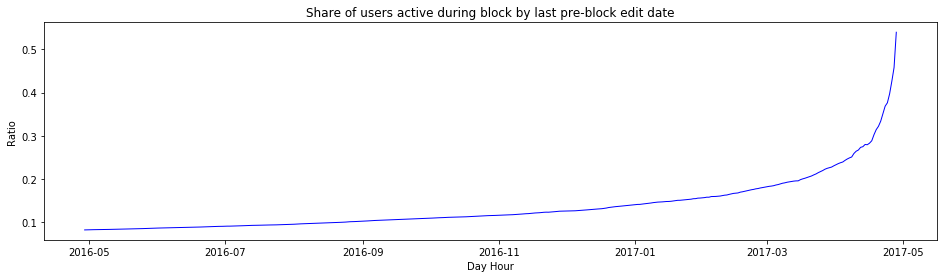

In [32]:
plt.figure(figsize=(16,4))
plt.title("Share of users active during block by last pre-block edit date")
plt.plot(preblock_dates[::-1], user_activity, color='blue', lw=1)
plt.ylabel("Ratio")
plt.xlabel("Day Hour")
plt.show()

In [49]:
plot_object = preblock_edit_counts.set_index('last_edit_before_block')['number_of_edits'].resample('6M').count()

In [50]:
plot_object.index = plot_object.index.strftime('%Y-%m')

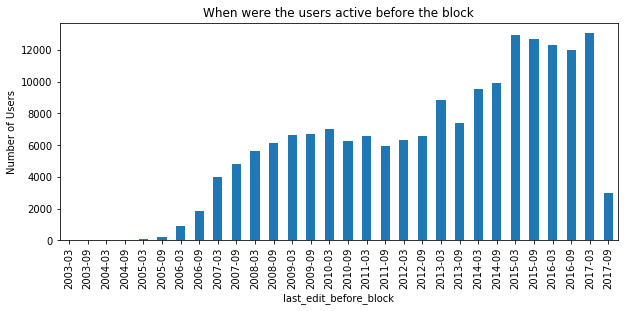

In [52]:
plt.figure(figsize=(10,4))
plot_object.plot(kind="bar")
plt.title("When were the users active before the block")
plt.ylabel('Number of Users')
plt.show()

In [262]:
preblock_edit_counts['number_of_edits'].describe()

count    177341.000000
mean         36.809390
std        1502.967584
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max      427314.000000
Name: number_of_edits, dtype: float64

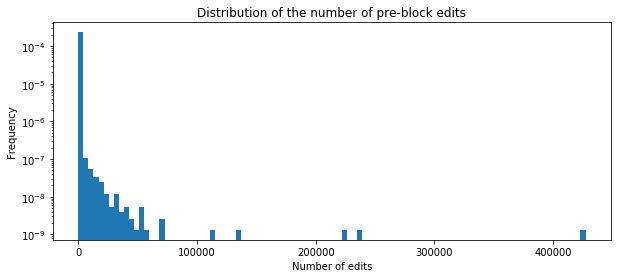

In [63]:
plt.figure(figsize=(10,4))
plt.hist(preblock_edit_counts['number_of_edits'], density=True, bins=100)
plt.yscale('log', nonposy='clip')
plt.title('Distribution of the number of pre-block edits')
plt.ylabel('Frequency')
plt.xlabel('Number of edits')
plt.show()

We see how disproportionate contributions to Turkish wikipedia are by the summary statistics and the plot above.

### 2) Editor activity levels by fixed number of daily edits.

In [64]:
preblock_edit_counts['edits_per_active_day'] = preblock_edit_counts['number_of_edits']/(1+(preblock_edit_counts['last_edit_before_block'] - preblock_edit_counts['first_edit_before_block']).dt.days)
preblock_edit_counts['edits_per_day'] = preblock_edit_counts['number_of_edits']/(1+(block_dates[0] - preblock_edit_counts['first_edit_before_block']).dt.days)

In [65]:
block_edit_counts['edits_per_day'] = block_edit_counts['number_of_edits']/((block_dates[1] - block_dates[0]).days)

In [66]:
preblock_edit_counts[preblock_edit_counts['last_edit_before_block'] >=  block_dates[0]-pd.Timedelta(days=900)].sort_values('edits_per_day', ascending=False)

,user_id,first_edit_before_block,last_edit_before_block,number_of_edits,edits_per_active_day,edits_per_day
115512,573665,2014-05-19 20:52:30+00:00,2017-04-28 21:16:47+00:00,223151,207.389405,207.389405
14760,90501,2007-06-01 13:23:34+00:00,2017-04-28 22:04:57+00:00,427314,118.042541,118.042541
43576,221544,2009-05-10 12:47:23+00:00,2017-04-28 19:06:33+00:00,238426,81.905187,81.905187
162031,882988,2016-06-25 17:39:57+00:00,2016-12-07 18:58:58+00:00,22224,133.879518,72.155844
164293,893615,2016-08-08 19:04:13+00:00,2017-04-28 23:00:36+00:00,12801,48.488636,48.488636
...,...,...,...,...,...,...
1955,10589,2007-05-17 16:25:50+00:00,2015-03-05 10:33:56+00:00,2,0.000702,0.000550
11976,73477,2007-03-15 16:55:29+00:00,2016-04-18 18:27:36+00:00,2,0.000602,0.000541
11168,67523,2007-02-20 17:57:29+00:00,2016-08-25 12:16:03+00:00,2,0.000576,0.000537
10959,65955,2007-02-13 07:33:45+00:00,2015-11-05 19:50:15+00:00,2,0.000627,0.000536


In [68]:
days_after_block = (edits['event_timestamp'].max()-block_dates[1]).days

In [69]:
active_preblock_editors = preblock_edit_counts[(preblock_edit_counts['last_edit_before_block'] >=  block_dates[0]-pd.Timedelta(days=30)) & (preblock_edit_counts['edits_per_day'] > 1)].sort_values('edits_per_day', ascending=False)

In [70]:
top_editors = pd.merge(active_preblock_editors, block_edit_counts, on = 'user_id', how='left')

In [71]:
top_editors.edits_per_day_x.describe(percentiles=[0.75, 0.90, 0.95, 0.99])

count    319.000000
mean       5.587758
std       14.676185
min        1.004638
50%        2.598658
75%        5.023623
90%        9.274827
95%       14.165663
99%       47.020682
max      207.389405
Name: edits_per_day_x, dtype: float64

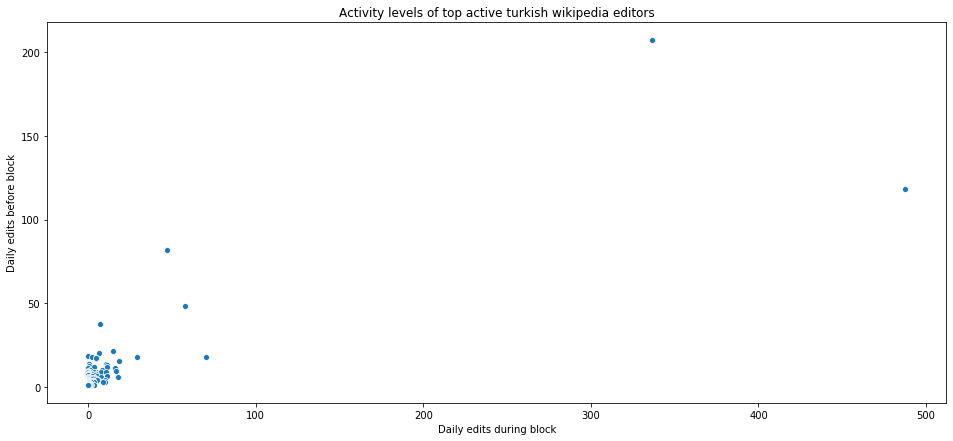

In [72]:
fig, ax = plt.subplots(figsize=(20,7))
ax.set_aspect('equal')
plt.title(f"Activity levels of top active turkish wikipedia editors")
sns.scatterplot(data=top_editors, x="edits_per_day_y", y="edits_per_day_x")
ax.set(xlabel='Daily edits during block', ylabel='Daily edits before block')
plt.show()

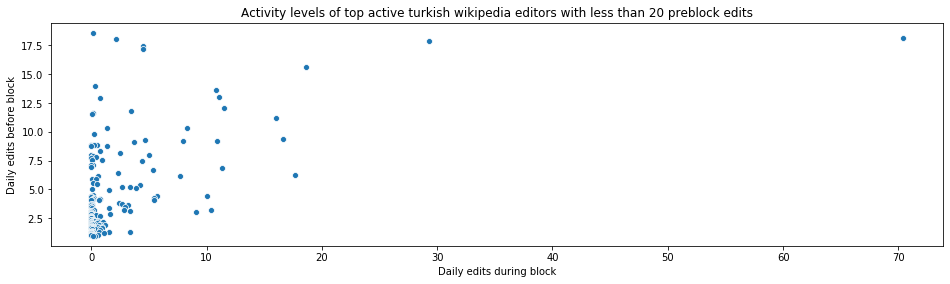

In [73]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_aspect('equal')
plt.title(f"Activity levels of top active turkish wikipedia editors with less than 20 preblock edits")
sns.scatterplot(data=top_editors[top_editors['edits_per_day_x'] < 20], x="edits_per_day_y", y="edits_per_day_x")
ax.set(xlabel='Daily edits during block', ylabel='Daily edits before block')
plt.show()

In [74]:
top_editors.describe()

,user_id,number_of_edits_x,edits_per_active_day,edits_per_day_x,number_of_edits_y,edits_per_day_y
count,319.000000,319.000000,319.000000,319.000000,174.000000,174.000000
mean,647473.564263,8270.429467,7.211913,5.587758,7769.528736,7.840090
std,342372.828615,31323.096188,15.110531,14.676185,44886.386853,45.294033
min,464.000000,2.000000,1.011204,1.004638,1.000000,0.001009
25%,326632.000000,17.000000,2.250517,1.616448,24.000000,0.024218
50%,805755.000000,1095.000000,3.666667,2.598658,235.500000,0.237639
75%,958503.000000,6891.000000,7.542118,5.023623,2635.750000,2.659687
max,964234.000000,427314.000000,207.389405,207.389405,483274.000000,487.662967


Here I bin the users by their daily edit activity for the preblock and the block periods. Having seen that Wikipedia itself has categorizations of users going from [0,1] edits per day and  [1, 5], [5, 25], [25, 99] and [99>] I decided to implement the same thing. However I guess that the daily edit rates is lower in turkish wikipedia than english wikipedia so this approach wasn't great. In later analysis, I changed these categories to daily edit activity percentiles.

In [75]:
bins = [0., 1., 5., 25., 99., 10000.]

In [76]:
top_editors['preblock_daily_edit_category'] = pd.cut(top_editors.edits_per_day_x, bins, right=False)
top_editors['block_daily_edit_category'] = pd.cut(top_editors.edits_per_day_y, bins, right=False)

In [77]:
edit_cats = pd.concat([top_editors.preblock_daily_edit_category.value_counts(dropna=False), top_editors.block_daily_edit_category.value_counts(dropna=False)], axis=1)

In [78]:
edit_cats = edit_cats.reset_index()

In [79]:
edit_cats.dtypes

index                           category
preblock_daily_edit_category     float64
block_daily_edit_category          int64
dtype: object

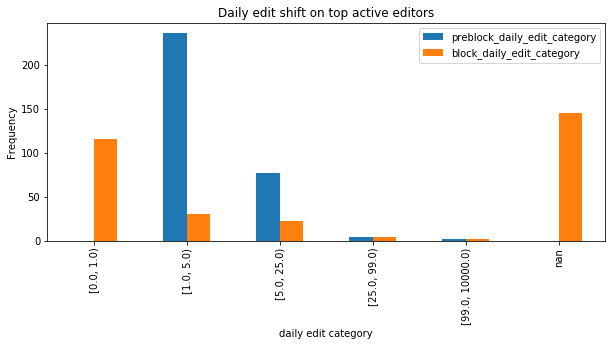

In [92]:
fig, ax = plt.subplots(figsize=(10,4))
edit_cats.plot.bar(x='index', ax=ax)

# The following commands add labels to our figure.
plt.xlabel('daily edit category')
plt.ylabel('Frequency')
plt.title(f'Daily edit shift on top active editors')

plt.show()

### 3) Analysing activity level changes for different user categories

In [81]:
daily_active_users = edits.set_index('event_timestamp').groupby(pd.Grouper(freq= 'D')).event_user_id.nunique()

In [82]:
daily_active_users = daily_active_users.reset_index()

In [83]:
daily_active_users = daily_active_users[daily_active_users['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

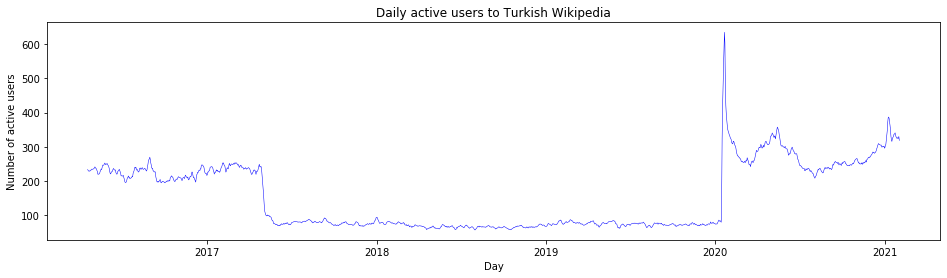

In [84]:
plt.figure(figsize=(16,4))
plt.title("Daily active users to Turkish Wikipedia")
rolling_mean = daily_active_users.rolling(window=7).mean()
plt.plot(daily_active_users.event_timestamp.values, rolling_mean, color='blue', lw=0.5)
plt.ylabel("Number of active users")
plt.xlabel("Day")
# for date in block_dates:
#     plt.axvline(date)
plt.show()

In [85]:
daily_active_users['period'] = daily_active_users.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

In [86]:
daily_active_users.groupby('period').describe()

event_user_id                                                      \
                    count        mean        std    min    25%    50%     75%   
period                                                                          
after-block         383.0  283.352480  71.960530  188.0  246.5  271.0  308.00   
block               992.0   73.993952  19.797970   40.0   67.0   73.0   79.25   
pre-block           382.0  227.052356  23.258953  154.0  212.0  228.0  243.00   

                     
                max  
period               
after-block  1285.0  
block         607.0  
pre-block     311.0

Wikipedia lost nearly 75% of their daily active users due to the block.

In [87]:
preblock_edit_counts['preblock_daily_edit_category'] = pd.cut(preblock_edit_counts.edits_per_day, bins, right=False)

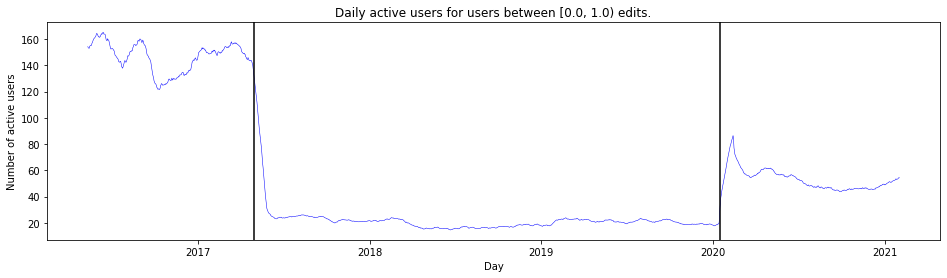

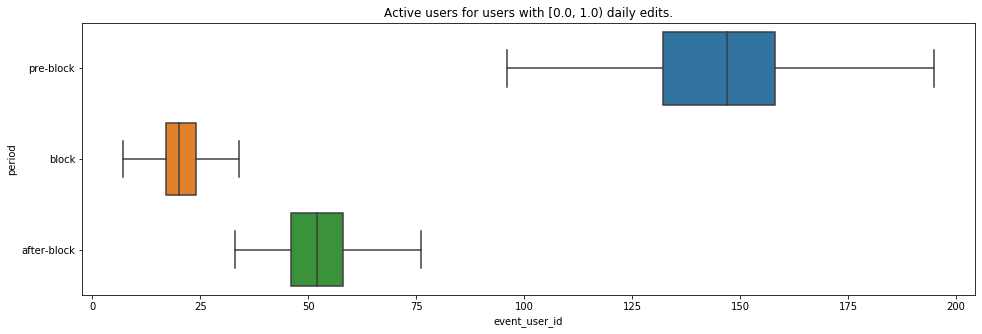

Activity change for [0.0, 1.0) users: -86.39455782312925%


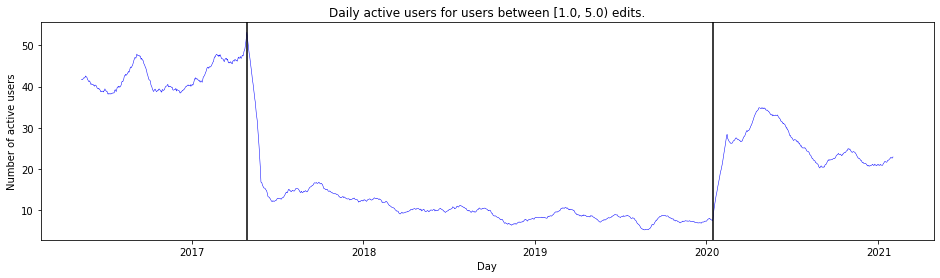

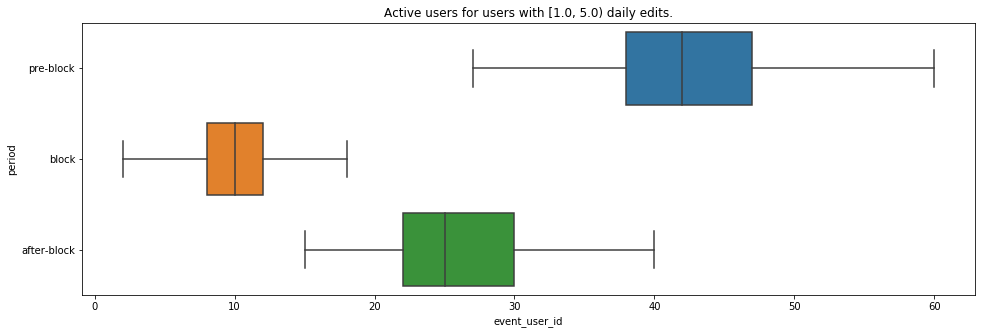

Activity change for [1.0, 5.0) users: -76.19047619047619%


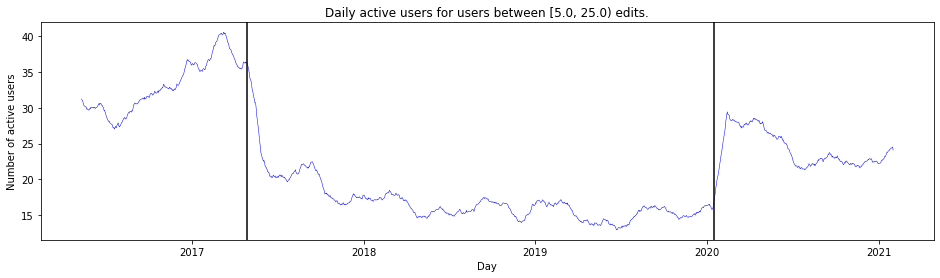

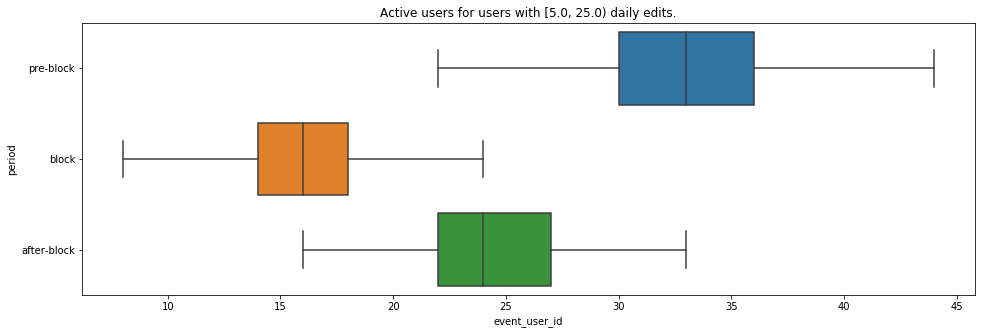

Activity change for [5.0, 25.0) users: -51.515151515151516%


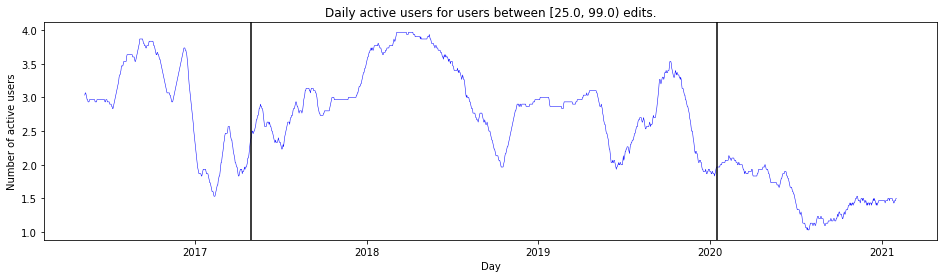

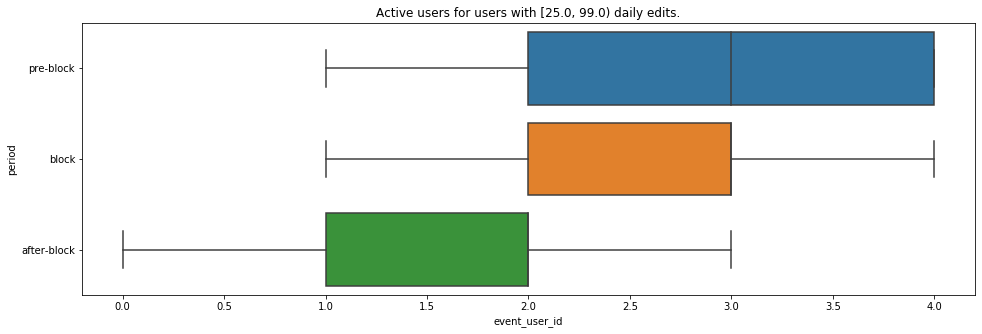

Activity change for [25.0, 99.0) users: 0.0%


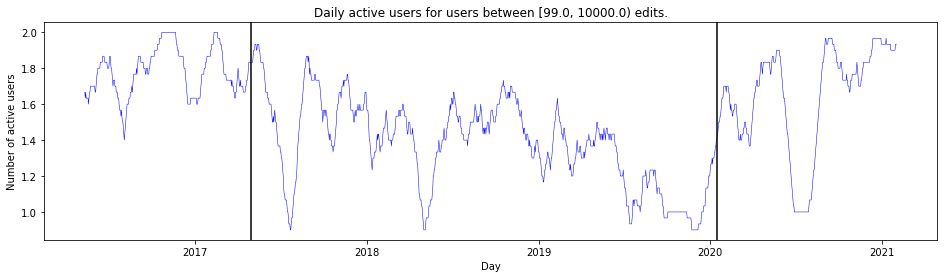

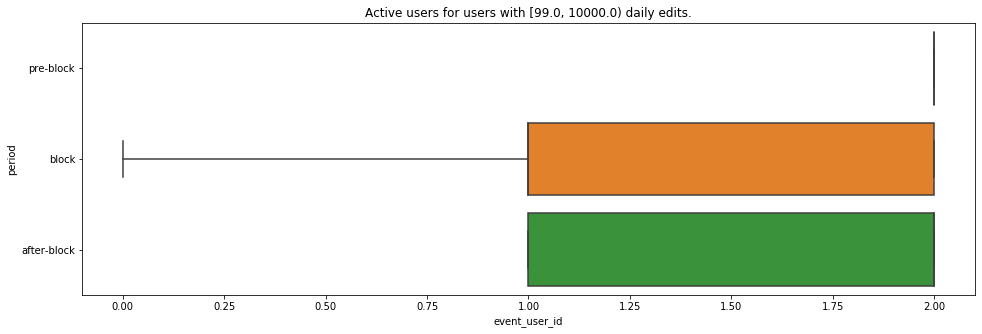

Activity change for [99.0, 10000.0) users: -50.0%


In [89]:
for category in sorted(preblock_edit_counts.preblock_daily_edit_category.unique()):
    category_users = preblock_edit_counts[preblock_edit_counts['preblock_daily_edit_category'] == category].user_id
    plt.figure(figsize=(16,4))
    plt.title(f"Daily active users for users between {category} edits.")
    df = edits[(edits['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=days_after_block))&(edits.event_user_id.isin(category_users))].set_index('event_timestamp').groupby(pd.Grouper(freq= 'D')).event_user_id.nunique().reset_index()
    rolling_mean = df.rolling(window=30).mean()
    plt.plot(df.event_timestamp.values, rolling_mean, color='blue', lw=0.5)
    plt.ylabel("Number of active users")
    plt.xlabel("Day")
    for date in block_dates:
        plt.axvline(date, color = 'black')
    plt.show()
    
    
    df['period'] = df.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)
    
    groups = df.groupby('period')
    periods = pd.concat([pd.DataFrame(x[1]['event_user_id'].values) for x in groups], axis=1)
    periods = pd.DataFrame(periods)
    periods.columns = range(1,4)
    fig, ax = plt.subplots()
    plt.title(f"Active users for users with {category} daily edits.")
    fig.set_size_inches(16, 5)
    plt.xlabel('Daily Active users')
    ax = sns.boxplot(y="period", x="event_user_id", data=df,  showfliers=False)
    plt.show()
    
    medians = groups.median()
    
    print(f"Activity change for {category} users: {100*(medians.values[1].item() - medians.values[2].item())/(medians.values[2].item())}%")

We can see that higher edit categories have between 1 to 4 active users a day. This categorisation is quite poor

## III. Create network of registered users


In [491]:
import networkx as nx

In [621]:
edits.head()

,event_user_id,event_timestamp,page_id,page_revision_count,revision_minor_edit,revision_text_bytes,revision_is_identity_revert,period
1,1,2002-12-05 22:54:39+00:00,5,1.0,False,24,False,pre-block
14,6,2003-03-13 16:30:04+00:00,10,1.0,False,8540,False,pre-block
51,13,2003-08-02 01:08:44+00:00,24,1.0,False,257,False,pre-block
52,13,2003-08-02 01:10:08+00:00,24,2.0,False,259,False,pre-block
53,13,2003-08-02 01:11:50+00:00,24,3.0,False,261,False,pre-block


In [625]:
print(f"Number of distinct editors : {len(edits.event_user_id.unique())}")

Number of distinct editors : 212768


### 1) Preblock graph 
Here we create a graph of active users in the preblock period. We restrict ourselves to a timeframe of similar size to the block period (i.e. 991 days before the ban). Nodes of the graph are users active in the pre-block period, and there exists and edge between two users if both users edited a same page during the pre-block period. The weight of the edges are the number of distinct pages that both users edited in common.


In [94]:
preblock_edits = edits[(edits['period'] == 'pre-block') & (edits['event_timestamp'] > block_dates[0]-pd.Timedelta(days=blocked_days))]

In [95]:
preblock_edits = preblock_edits.groupby('event_user_id')['page_id'].apply(set)

In [657]:
preblock_edits = preblock_edits.reset_index()

In [646]:
preblock_adjacency = np.zeros((preblock_edits.shape[0], preblock_edits.shape[0]))

In [662]:
for i, elem1 in preblock_edits.page_id.iteritems():
    for j, elem2 in preblock_edits.page_id.iteritems():
        if i > j:
            intersection = len(elem1.intersection(elem2))
            preblock_adjacency[i,j] = intersection
            preblock_adjacency[j,i] = intersection

In [684]:
preblock_graph = nx.from_numpy_array(preblock_adjacency)

In [685]:
nx.write_gexf(preblock_graph, 'preblock_graph.gexf')

In [686]:
print('Number of nodes: {}, Number of edges: {}'. format(preblock_graph.number_of_nodes(), preblock_graph.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(preblock_graph), nx.number_connected_components(preblock_graph)))

Number of nodes: 68827, Number of edges: 2326737
Number of self-loops: 0, Number of connected components: 5367


In [699]:
giant_preblock = preblock_graph.subgraph(max(nx.connected_components(preblock_graph), key=len))
print('The giant component of the preblock graph has {} nodes and {} edges.'.format(giant_preblock.number_of_nodes(), giant_preblock.size()))

The giant component of the preblock graph has 63390 nodes and 2326653 edges.


In [717]:
print(f'The clustering coefficient of the preblock graph is {nx.average_clustering(preblock_graph)}')

KeyboardInterrupt: 

### 2) Block graph 
The block graph is similar to the preblock graph. The ```.gexf``` files can be found in ```/dlabdata1/turkish_wiki/graphs/```.

In [14]:
block_edits = edits[(edits['period'] == 'block')]

In [664]:
block_edits = block_edits.groupby('event_user_id')['page_id'].apply(set)

In [665]:
block_edits = block_edits.reset_index()

In [666]:
block_adjacency = np.zeros((block_edits.shape[0], block_edits.shape[0]))

In [671]:
for i, elem1 in block_edits.page_id.iteritems():
    for j, elem2 in block_edits.page_id.iteritems():
        if i > j:
            intersection = len(elem1.intersection(elem2))
            block_adjacency[i,j] = intersection
            block_adjacency[j,i] = intersection

In [702]:
block_graph =  nx.from_numpy_array(block_adjacency)

In [703]:
nx.write_gexf(block_graph, 'block_graph.gexf')

In [704]:
print('Number of nodes: {}, Number of edges: {}'. format(block_graph.number_of_nodes(), block_graph.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(block_graph), nx.number_connected_components(block_graph)))


Number of nodes: 13119, Number of edges: 130517
Number of self-loops: 0, Number of connected components: 1026


In [706]:
giant_block = block_graph.subgraph(max(nx.connected_components(block_graph), key=len))
print('The giant component of the block graph has {} nodes and {} edges.'.format(giant_block.number_of_nodes(), giant_block.size()))

The giant component of the block graph has 12085 nodes and 130508 edges.


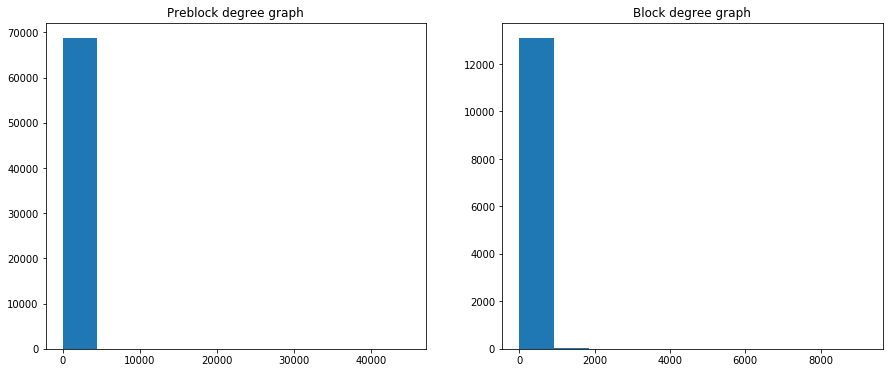

In [709]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Preblock degree graph')
preblock_degrees = [degree for node, degree in preblock_graph.degree()]
axes[0].hist(preblock_degrees);
axes[1].set_title('Block degree graph')
block_degrees = [degree for node, degree in block_graph.degree()]
axes[1].hist(block_degrees);

In [ ]:
print(f'The clustering coefficient of the block graph is {nx.average_clustering(block_graph)}')

### 3) Find out if those who remained were a subcommunity of the pre-block graph

In [723]:
users_who_remained = list(set(preblock_edits.event_user_id.values).intersection(set(block_edits.event_user_id.values)))

In [728]:
users_who_remained_idx = preblock_edits[preblock_edits['event_user_id'].isin(users_who_remained)].index.values

In [760]:
users_who_left_idx = list(preblock_edits[~preblock_edits['event_user_id'].isin(users_who_remained)].index.values)

In [732]:
unaffected_community = nx.subgraph(preblock_graph, users_who_remained_idx)
rest_of_graph = nx.subgraph(preblock_graph, users_who_left_idx)

#### 1) Strong community
The subgraph V is a community in a strong sense if each node has more connections within the community than with the rest of the graph. 

#### 2) Weak community
The subgraph V is a community in a weak sense if the sum of all degrees within V is larger than the sum of all degrees toward the rest of the network.

In [743]:
degrees_within_community = sum(dict(unaffected_community.degree()).values())

In [776]:
degrees_to_the_rest = 0
for user_idx in users_who_remained_idx:
    user_and_rest = users_who_left_idx.copy()
    user_and_rest.append(user_idx)
    rest_of_network = nx.subgraph(preblock_graph, user_and_rest)
    degrees_to_the_rest += nx.degree(rest_of_network, user_idx)

In [777]:
degrees_to_the_rest

1123868

In [778]:
degrees_within_community

201302

The users who remained do not form a strong or weak community inside the pre-block network. It is possible that the timeframe that we took for the pre-block period is too much. We took a symmetrical period to the pre-block period, the block lasted 991 days, but a lot of the users in the pre-block period already left wikipedia a long time ago. The sum of degrees within the users who remained is 5 times smaller than the degrees to the rest of the network whilst there are 23 times more users outside the community than inside.

### 4) Use community algorithms and check if users who remained are in it
The below measures took too much time to compute on the scale of graphs that we had and were abandoned. Another approach to understand the user networks were employed later on in the notebooks ```get_graphs.ipynb``` and ```analyze_graphs.ipynb```.

#### Centrality based - Girvan Newman

In [792]:
from networkx.algorithms import community
girvan_newman_communities_generator = community.girvan_newman(preblock_graph)
top_level_communities = next(girvan_newman_communities_generator)

#### Modularity based

##### Weighted

In [ ]:
modularity_communities_generator = community._naive_greedy_modularity_communities(preblock_graph)
top_level_communities = next(modularity_communities_generator)


##### Unweighted

In [805]:
uw_modularity_communities_generator = community.greedy_modularity_communities(preblock_graph)
top_level_communities = next(uw_modularity_communities_generator)


KeyboardInterrupt: 

## IV. Implementing measures of the Romero paper
Romero and al. implemented some metrics to measure the changes in activity of Chinese Wikipedia during censorship times. Here we replicate the measures to analyze them in the context of Turkish Wikipedia. All measures are article based, meaning that we have values at an article level.

### 1) Shock level
Given an article a, we define the weighted
blocked ratio $B_a$ of article a as the fraction of edits contributed
by the editors blocked among all the edits during
the pre-block period.

In [ ]:
preblock_edits = edits[(edits['period'] == 'pre-block') & (edits['event_timestamp'] > block_dates[0]-pd.Timedelta(days=blocked_days))]
block_edits = edits[(edits['period'] == 'block')]

users_who_remained = list(set(preblock_edits.event_user_id.values).intersection(set(block_edits.event_user_id.values)))
users_who_left = list(set(preblock_edits.event_user_id.values).difference(set(block_edits.event_user_id.values)))

preblock_edits['blocked_user'] = preblock_edits['event_user_id'].isin(users_who_left)

all_pages = preblock_edits.groupby(['page_id']).size().reset_index()
blocked_user_pages = preblock_edits[preblock_edits['blocked_user'] == True].groupby(['page_id']).size().reset_index()

shock_level = pd.merge(all_pages, blocked_user_pages, on = 'page_id', how = 'left')

shock_level.columns = ['page_id', 'all_edits_count', 'blocked_user_edits_count']
shock_level = shock_level.fillna(0)

shock_level['blocked_ratio'] = shock_level['blocked_user_edits_count']/shock_level['all_edits_count']

In [869]:
shock_level.head()

,page_id,all_edits_count,blocked_user_edits_count,blocked_ratio
0,5,2,1.0,0.500000
1,10,247,74.0,0.299595
2,16,2,0.0,0.000000
3,22,56,21.0,0.375000
4,24,90,58.0,0.644444


In [868]:
shock_level.to_csv(f"{DATA_PATH}/processed_data/shock_level.csv")

### 2) Level of Activity
For each article a, we let $EV^{pre}_a$ and $EV^{post}_a$ be the number of edits of a made during the pre-block
period and block period, respectively. <br>
Then, $EV^Δ_a = \frac{EV^{post}_a −EV^{pre}_a}{EV^{pre}_a}$

In [876]:
level_of_activity = pd.merge(preblock_edits[['page_id']].groupby('page_id').size().reset_index().rename(columns={0: "preblock_edit_count"}), block_edits[['page_id']].groupby('page_id').size().reset_index().rename(columns={0: "block_edit_count"}), on='page_id', how='outer')

In [878]:
level_of_activity = level_of_activity[~level_of_activity['preblock_edit_count'].isna()]

In [880]:
level_of_activity = level_of_activity.fillna(0)

In [881]:
level_of_activity['delta'] = (level_of_activity['block_edit_count'] - level_of_activity['preblock_edit_count'])/(level_of_activity['preblock_edit_count'])

In [882]:
level_of_activity.to_csv(f"{DATA_PATH}/processed_data/level_of_activity.csv")

### 3) Centralization
We let $E^{pre}_a$ and $E^{post}_a$ be the set of editors of article a in the pre-block and post-block period, respectively, and $N^{pre}_a$ and $N^{post}_a$ be the number of editors in $E^{pre}_a$ and $E^{post}_a$ . We let $W^{pre}_a (e)$ and $W^{post}_a (e)$ be the number of times editor e contributed to article a in the respective time periods. We begin by computing the $G^{pre}_a$ , the Gini coefficient of the set ${\bigcup_{e \in E^{pre}_a} W^{pre}_a (e)}$: <br>
$G^{pre}_a = \frac{ \sum_{i \in E^{pre}_a} \sum_{j \in E^{pre}_a}|e_i−e_j|}{2\sum_{i∈E^{pre}_a}\sum_{j∈E^{pre}_a}e_j}$

We define the centralization of article a during the pre-block period, $C^{pre}_a$  , as the fraction of $G^{pre}_a$ and the maximum value of $G_a$ given $E^{pre}_a$ and $EV^{pre}_a$ . We also define the corresponding measures of centralization of an article during the post-block period in the same manner. Finally, we define the change in centralization as $C^Δ_a=C^{post}_a −C^{pre}_a $.

In [904]:
from collections import Counter

In [905]:
eprea = preblock_edits.groupby('page_id')['event_user_id'].apply(list).apply(Counter)

In [906]:
eposta = block_edits.groupby('page_id')['event_user_id'].apply(list).apply(Counter)

In [907]:
gini = pd.merge(eprea.reset_index(), eposta.reset_index(), on = 'page_id', how = 'outer')

In [908]:
gini.columns = ['page_id', 'eprea', 'eposta']

In [963]:
def calculate_gini(c):
    if(pd.notnull(c)):
        values = list(c.values())
        num = 0
        denom = 0

        for i in values:
            for j in values:
                num += abs(i-j)
                denom += j
        return num/(2*denom)

In [966]:
gini['gprea'] = gini['eprea'].apply(calculate_gini)
gini['gposta'] = gini['eposta'].apply(calculate_gini)

In [967]:
gini

,page_id,eprea,eposta,gprea,gposta
0,5,"{800643: 1, 113659: 1}",NaN,0.000000,NaN
1,10,"{223619: 2, 464885: 2, 400394: 1, 650845: 1, 6...","{208697: 3, 573665: 6, 104002: 1, 880664: 1, 3...",0.625091,0.335979
2,16,"{93111: 1, 96765: 1}",NaN,0.000000,NaN
3,22,"{248688: 1, 5516: 1, 416618: 1, 673356: 1, 536...","{748781: 3, 573665: 2, 90501: 1}",0.470497,0.222222
4,24,"{365127: 29, 166490: 11, 626925: 1, 642240: 2,...","{573665: 2, 136954: 1, 221544: 1, 86010: 1, 10...",0.562007,0.260000
...,...,...,...,...,...
453997,2607910,NaN,{996784: 1},NaN,0.000000
453998,2616902,NaN,{90501: 1},NaN,0.000000
453999,2625246,NaN,"{90501: 1, 136954: 1}",NaN,0.000000
454000,2648641,NaN,{90501: 1},NaN,0.000000


In [975]:
gini['evprea'] = gini['eprea'].apply(lambda c: sum(c.values()) if(pd.notnull(c)) else 0)
gini['evposta'] = gini['eposta'].apply(lambda c: sum(c.values()) if(pd.notnull(c)) else 0)

In [978]:
gini['nprea'] = gini['eprea'].apply(lambda c: len(c.keys()) if(pd.notnull(c)) else 0)
gini['nposta'] = gini['eposta'].apply(lambda c: len(c.keys()) if(pd.notnull(c)) else 0)

In [1000]:
def max_gini(ev, n):
    """
    Returns the maximum possible gini value
    
    Params
    ------
        ev: int : Number of edits
        n: int : Number of users
    """
    if n>0:
        return (n-1)*(ev-n)/(ev*n)

In [1009]:
gini['max_pre_gini'] = gini[['evprea', 'nprea']].apply(lambda row: max_gini(row['evprea'], row['nprea']), axis=1)
gini['max_post_gini'] = gini[['evposta', 'nposta']].apply(lambda row: max_gini(row['evposta'], row['nposta']), axis=1)

In [1015]:
gini['normalized_gprea'] = gini[['gprea', 'max_pre_gini']].apply(lambda row: row['gprea']/row['max_pre_gini'], axis=1)
gini['normalized_gposta'] = gini[['gposta', 'max_post_gini']].apply(lambda row: row['gposta']/row['max_post_gini'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [1019]:
gini['cdelta'] = gini['normalized_gposta'] - gini['normalized_gprea']

In [1022]:
gini.to_csv(f'{DATA_PATH}/processed_data/gini.csv')

### 4) Conflict
We let $R_{a}^{pre}$ and $R_{a}^{post}$ be the revert rates of article $a$ in the pre-block and post-block periods, respectively. We define the change in conflict in an article as $R_{a}^{\Delta}=R_{a}^{\text {post }}-R_{a}^{\text {pre }}$

In [32]:
conflict = pd.merge(preblock_edits[preblock_edits['revision_is_identity_revert'] == True].groupby('page_id').size().reset_index().rename(columns={0: "preblock_reverts"}), preblock_edits.groupby('page_id').size().reset_index().rename(columns={0: "preblock_edits"}), how = 'outer')

In [35]:
conflict = pd.merge(conflict, pd.merge(block_edits[block_edits['revision_is_identity_revert'] == True].groupby('page_id').size().reset_index().rename(columns={0: "block_reverts"}), block_edits.groupby('page_id').size().reset_index().rename(columns={0: "block_edits"}), how = 'outer') ,how = 'outer')

In [38]:
conflict = conflict.fillna(0)

In [40]:
conflict['preblock_revert_rate'] = conflict['preblock_reverts']/conflict['preblock_edits']
conflict['block_revert_rate'] = conflict['block_reverts']/conflict['block_edits']
conflict['change'] = conflict['block_revert_rate'] - conflict['preblock_revert_rate']

In [41]:
conflict

,page_id,preblock_reverts,preblock_edits,block_reverts,block_edits,preblock_revert_rate,block_revert_rate,change
0,5,1.0,2.0,0.0,0.0,0.500000,NaN,NaN
1,10,62.0,247.0,4.0,27.0,0.251012,0.148148,-0.102864
2,22,8.0,56.0,2.0,6.0,0.142857,0.333333,0.190476
3,24,17.0,90.0,2.0,15.0,0.188889,0.133333,-0.055556
4,30,5.0,12.0,0.0,12.0,0.416667,0.000000,-0.416667
...,...,...,...,...,...,...,...,...
453997,2607910,0.0,0.0,0.0,1.0,NaN,0.000000,NaN
453998,2616902,0.0,0.0,0.0,1.0,NaN,0.000000,NaN
453999,2625246,0.0,0.0,0.0,2.0,NaN,0.000000,NaN
454000,2648641,0.0,0.0,0.0,1.0,NaN,0.000000,NaN


In [42]:
conflict.to_csv(f'{DATA_PATH}/processed_data/conflict.csv', index =False)